## Project 2 Starting Over
Jacob Minkin
Last project I tried to predict a critical violation from location and cuisine. The problem is that almost all restaurants have at least one critical violation which made it hard to get any predictive value from the model. Now I want to try again with predicting the score and therefore grade of the restaurant

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pickle
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
sns.set_style('darkgrid')

#Import Data
df = pd.read_csv('../data/Inspection.csv')
df['date'] = pd.to_datetime(df['INSPECTION DATE'])
df = df[df.BORO == 'Manhattan']
df.sort_values(['date'], ascending=False, inplace= True)
df = df.groupby(['CAMIS'], sort=False).first()
df = df[df['INSPECTION DATE'] != '1/1/1900']

In [273]:
df

,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE,INSPECTION DATE,ACTION,VIOLATION CODE,...,BIN,BBL,NTA,Location Point,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts,date
CAMIS,,,,,,,,,,,,,,,,,,,,,
50114345,PHALIA,Manhattan,126,LEXINGTON AVENUE,10016.0,6463705380,Pakistani,2/11/2023,Establishment re-opened by DOHMH.,10F,...,1018209.0,1.008840e+09,MN20,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-11
50067994,DOMINICAN VALLE RESTAURANT,Manhattan,1601,SAINT NICHOLAS AVENUE,10040.0,6468690092,Spanish,2/10/2023,Violations were cited in the following area(s).,02G,...,1064035.0,1.021690e+09,MN35,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-10
50036864,PRESTO FRESH CAFE,Manhattan,559,LENOX AVENUE,10037.0,3476849436,Spanish,2/10/2023,Violations were cited in the following area(s).,08A,...,1060031.0,1.020078e+09,MN03,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-10
50057298,HANDCRAFT COFFEE,Manhattan,151,EAST 77 STREET,10075.0,6469227025,Coffee/Tea,2/10/2023,Violations were cited in the following area(s).,06E,...,1043195.0,1.014120e+09,MN40,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-10
50085148,BEST PIZZA II,Manhattan,1140,1 AVENUE,10065.0,2128385080,Pizza,2/10/2023,Violations were cited in the following area(s).,10B,...,1045319.0,1.014570e+09,MN31,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41226031,ARS NOVA THEATER,Manhattan,511,WEST 54 STREET,10019.0,2124899800,American,10/17/2018,Violations were cited in the following area(s).,05D,...,1027060.0,1.010830e+09,MN15,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-17
40560953,GOLDEN THEATRE,Manhattan,252,WEST 45 STREET,10036.0,2125752914,American,10/17/2018,Violations were cited in the following area(s).,04A,...,1024717.0,1.010160e+09,MN17,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-17
40944945,Stage 42,Manhattan,422,WEST 42 STREET,10036.0,2125867610,American,9/19/2018,Violations were cited in the following area(s).,04N,...,1087184.0,1.010518e+09,MN15,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-19


In [274]:
with open('distance.pickle', 'rb') as handle:
    distance_to_subway = pickle.load(handle)
with open('subway_lines.pickle', 'rb') as handle:
    closest_station = pickle.load(handle)

In [275]:
cuisine_categories = pd.read_csv('../data/cuisine_categories.csv')
#cuisine_categories.info()

df['CAMIS'] = df.index
TempList = ['CUISINE', 'Subgroup']
df = pd.merge(df, cuisine_categories[TempList], on= 'CUISINE',how='left').set_index('CAMIS')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9083 entries, 50114345 to 50043445
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DBA                     9083 non-null   object        
 1   BORO                    9083 non-null   object        
 2   BUILDING                9072 non-null   object        
 3   STREET                  9083 non-null   object        
 4   ZIPCODE                 8911 non-null   float64       
 5   PHONE                   9083 non-null   object        
 6   CUISINE                 9083 non-null   object        
 7   INSPECTION DATE         9083 non-null   object        
 8   ACTION                  9083 non-null   object        
 9   VIOLATION CODE          9060 non-null   object        
 10  VIOLATION               9060 non-null   object        
 11  CRITICAL FLAG           9083 non-null   object        
 12  SCORE                   9082 non-null

In [276]:
df['sub_dis'] = df.index.map(distance_to_subway)

In [277]:
keys = ['M', 'R', 'F', '6', 'B', 'C', '1', '2', 'D', 'E', '5', 'A', '7', 'N', 'Q', '4', '3', 'L', 'G', 'J', 'Z', 'S']
for i in keys:
    df[i] = df.index.map({id: '1' if id in closest_station[i] else '0' for id in df.index})    

In [278]:
df.DBA

CAMIS
50114345                         PHALIA
50067994     DOMINICAN VALLE RESTAURANT
50036864              PRESTO FRESH CAFE
50057298               HANDCRAFT COFFEE
50085148                  BEST PIZZA II
                       ...             
41226031               ARS NOVA THEATER
40560953                 GOLDEN THEATRE
40944945                       Stage 42
50046091                   PLAYROOM NYC
50043445    VICTORY CAFE (Armory Track)
Name: DBA, Length: 9083, dtype: object

In [279]:
Name_list = df.DBA.unique()
Name_dicts = {}
Restaurant_Chain = df.DBA.value_counts()
#score_dicts = {}
for name in Name_list:
    Name_dicts[name] = Restaurant_Chain[name]


df['num_restaurants'] = df['DBA'].map(Name_dicts)
df['is_chain'] = df['num_restaurants'].apply(lambda x: 1 if x > 2 else 0)

In [384]:
Predictor_list = ['SCORE', 'sub_dis', 'Subgroup', 'is_chain', 'M', 'R', 'F', '6', 'B', 'C', '1', '2', 'D', 'E', '5', 'A', '7', 'N', 'Q', '4', '3', 'L', 'G', 'J', 'Z', 'S']
df_test = df[Predictor_list]
df_test = df_test[(df_test.SCORE.notnull()) & (df_test.Subgroup.notnull())& (df_test.sub_dis.notnull())]


Subgropup_df = pd.get_dummies(df_test['Subgroup'])
df_test = df_test.drop('Subgroup', axis = 1)

df_test = pd.merge(df_test, Subgropup_df, on='CAMIS')

y = df_test.SCORE
df_test = df_test.drop('SCORE', axis = 1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8893 entries, 50114345 to 50043445
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sub_dis            8893 non-null   float64
 1   is_chain           8893 non-null   int64  
 2   M                  8893 non-null   object 
 3   R                  8893 non-null   object 
 4   F                  8893 non-null   object 
 5   6                  8893 non-null   object 
 6   B                  8893 non-null   object 
 7   C                  8893 non-null   object 
 8   1                  8893 non-null   object 
 9   2                  8893 non-null   object 
 10  D                  8893 non-null   object 
 11  E                  8893 non-null   object 
 12  5                  8893 non-null   object 
 13  A                  8893 non-null   object 
 14  7                  8893 non-null   object 
 15  N                  8893 non-null   object 
 16  Q            

In [385]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [386]:
X_train, X_test, y_train, y_test = train_test_split(df_test, y, test_size=0.2, random_state=42)

In [387]:
from sklearn.linear_model import LinearRegression

linmod = LinearRegression()

linmod.fit(y =y , X=df_test)

# Calculate Accuracy
accuracy = linmod.score(y = y, X= df_test)
print(f"Model accuracy: {accuracy}")

# Look at betas (coefficients)
betas = linmod.coef_
print(f"Betas: {betas}")

y_pred = linmod.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("R^2 Score: %0.2f" % r2)
print("Mean Squared Error: %0.2f" % mse)

Model accuracy: 0.038958721838999066
Betas: [  0.20995759  -2.70744731   0.92473741 -14.01214374  -1.49080795
  -0.3165277   -1.41309122   0.99183479   0.02290119  -5.74677737
   1.00048839  -1.91727967  -0.16295902   0.38364953   0.20058395
  12.85717206   0.45165776  -0.16295902   4.50432094   1.05186701
   0.0166596   -0.40512057  -0.40512057   1.65764034  -1.35583768
  -0.24400947  -3.68563631  -2.25631662   1.6639273    1.62872269
  -0.4397701   -1.39491159   0.26026143   3.3981421   -0.36465249
   0.30740857   0.07305471  -2.39858101   0.91759053   0.92627098
  -1.7947004    0.65070518   1.06119695   3.04713523]
R^2 Score: 0.04
Mean Squared Error: 115.67


In [388]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=5, n_estimators= 200, min_samples_leaf = 1,  min_samples_split = 2 , random_state=300)
rf.fit(X_train,y_train)
predictions_train = rf.predict(X_train)
predictions_test = rf.predict(X_test)

score = rf.score(X_test, y_test)
print(f"Accuracy: {score:.2f}")

Accuracy: 0.02


In [389]:
from sklearn import metrics
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("R^2 Score: %0.2f" % r2)
print("Mean Squared Error: %0.2f" % mse)

R^2 Score: 0.02
Mean Squared Error: 117.39


In [390]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [ 200, 250, 300],
    'max_depth': [None, 5,6,7 ,8,9,10 ],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=0)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


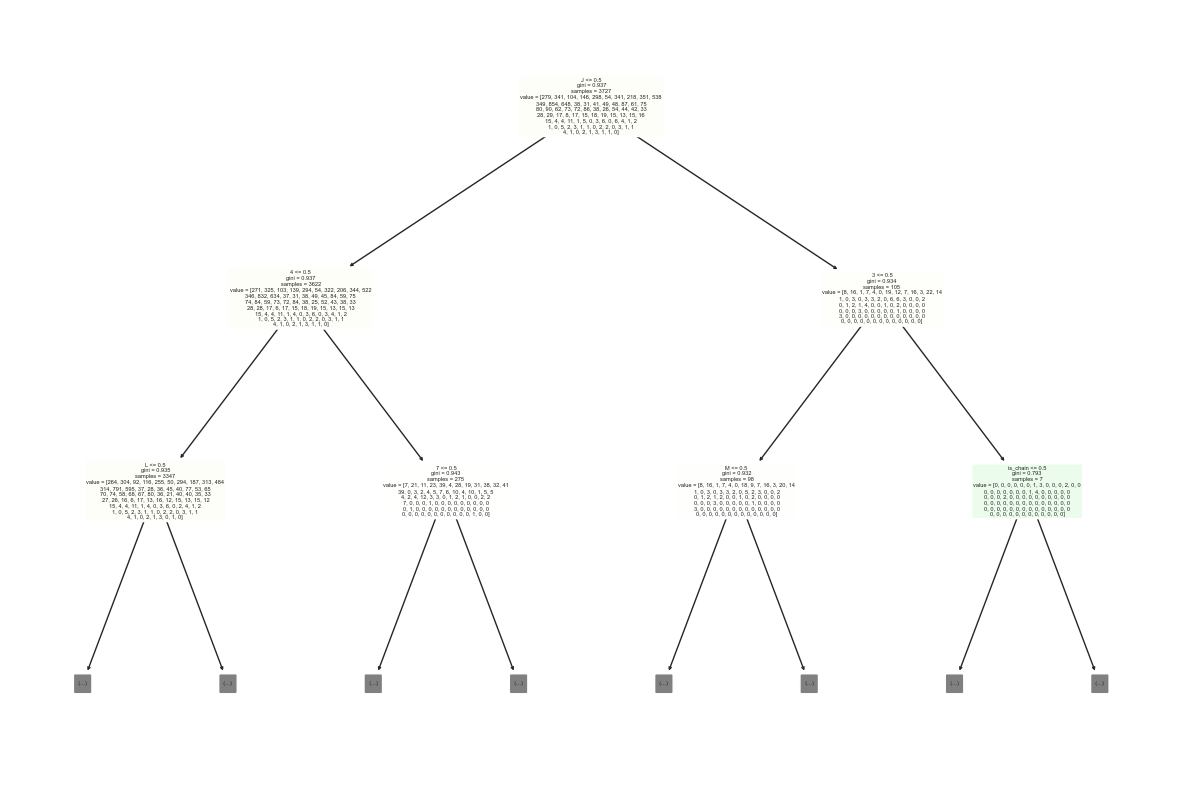

In [313]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(
          forest.estimators_[0], 
          max_depth = 2,
          feature_names=X_train.columns,
          filled=True, rounded=True)

plt.show()

## FINAL TEST

## BAGGING

In [391]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree classifier
tree = DecisionTreeRegressor()

# Create a bagging classifier
bagging = BaggingRegressor(tree, n_estimators=100)

# Train the model on the training data
bagging.fit(X_train, y_train)

# Evaluate the model on the testing data
training_score = bagging.score(X_train, y_train)
print("Training Accuracy:", training_score)
score = bagging.score(X_test, y_test)
print("Test Accuracy:", score)

y_pred = bagging.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("R^2 Score: %0.2f" % r2)
print("Mean Squared Error: %0.2f" % mse)

Training Accuracy: 0.8122173963057286
Test Accuracy: -0.19141241151254595
R^2 Score: -0.19
Mean Squared Error: 143.40


In [371]:
# Create a decision tree classifier
tree = DecisionTreeRegressor()

# Create a bagging classifier
bagging = BaggingRegressor(tree)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0]
}

# Create the grid search object
grid_search = GridSearchCV(bagging, param_grid=param_grid)

# Train the model on the training data using grid search
grid_search.fit(X_train, y_train)

# Evaluate the model on the testing data
training_score = grid_search.score(X_train, y_train)
print("Training Accuracy:", training_score)
score = grid_search.score(X_test, y_test)
print("Accuracy:", score)

Training Accuracy: 0.31120073746280075
Accuracy: 0.0046711157885325205


In [245]:
training_score = grid_search.score(X_train, y_train)
print("Training Accuracy:", training_score)

Training Accuracy: 0.918932527693857


In [392]:
from sklearn.model_selection import cross_val_score

# Create a Bagging Classifier with a Decision Tree base estimator
bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor())

# Use cross-validation to determine how many boosting steps to take
scores = cross_val_score(bagging, X_train, y_train, cv=5)

# Find the number of boosting steps that gives the highest score
n_estimators = np.argmax(scores) + 1

# Train the Bagging Classifier with the optimal number of boosting steps
bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=n_estimators)
bagging.fit(X_train, y_train)

y_pred = bagging.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

training_score = bagging.score(X_train, y_train)
print("Training Accuracy:", training_score)
score = bagging.score(X_test, y_test)
print("Test Accuracy:", score)

Training Accuracy: 0.7047691635357196
Test Accuracy: -0.294160539550016


In [374]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a gradient boosting classifier
clf = GradientBoostingRegressor(random_state=0)

# Train the model on the training data
clf.fit(X_train, y_train)

# Evaluate the model on the testing data
score = clf.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.022332504483446036


In [355]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor


bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                            n_estimators=10,
                            random_state=0).fit(X_train, y_train)
y_pred = bagging.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("R^2 Score: %0.2f" % r2)
print("Mean Squared Error: %0.2f" % mse)

#print("Accuracy: %0.2f" % accuracy)
# score = bagging.score(X_train, y_train)
# print("Train Accuracy:", score)

# score = bagging.score(X_test, y_test)
# print("Test Accuracy:", score)

R^2 Score: -0.28
Mean Squared Error: 154.37


In [336]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score



bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                            n_estimators=10,
                            random_state=0)

scores = cross_val_score(bagging, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: -0.28 (+/- 0.08)


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [410]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
X_train, X_test, y_train, y_test = train_test_split(df_test, y, test_size=0.33, random_state=42)
# Create a Lasso object
lasso = Lasso(alpha=0.15)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler object to the data
scaler.fit(X_train)

# Transform the training and test data using the scaler object
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Lasso object to the scaled data
lasso.fit(X_train_scaled, y_train)

# Print the coefficients of the Lasso object
print(f"Coefficients: {lasso.coef_}")

# Predict the test data using the Lasso object
y_pred = lasso.predict(X_test)

# Calculate mean squared error (MSE) of predictions
mse = mean_squared_error(y_test, y_pred)
r2_score = lasso.score(X_test, y_test)
print(f'R-squared score: {r2_score:.2f}')
print(f'Mean squared error: {mse:.2f}')

Coefficients: [-0.         -0.86191941 -0.         -0.11282949 -0.27779705 -0.
  0.          0.          0.         -0.0319374   0.05029854 -0.02519345
 -0.          0.         -0.         -0.01908944  0.         -0.
 -0.          0.         -0.         -0.         -0.          0.
 -0.53842179  0.         -0.17154709 -0.70884304  0.54176755 -0.
 -0.         -0.          0.          0.18596556 -0.00866112  0.
  0.         -0.09196212  0.06259827  0.00570409 -0.18465789  0.
  0.          0.27825212]
R-squared score: 0.01
Mean squared error: 113.86


c:\Users\logic_switch\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\logic_switch\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
